In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve



In [23]:
# Load data
data = pd.read_csv('patients_data_with_RVoutcomes.csv')

# Clean data
data = data.dropna(subset=['Birthday', 'RV Dysfunction'])
data = data[data['RV Dysfunction'] != '0']

# Select features
columns_to_exclude = ['patid', 'patkey', 'rhcId','RHCDate', 'TTEDate', 'AVr_str', 'PVr_str', 'TVr_str', 'MVr_str']
data = data.drop(columns=columns_to_exclude)

In [24]:
missing_percentages = data.isnull().mean() * 100

# Identify columns with more than 20% missing data
columns_to_drop = missing_percentages[missing_percentages > 20].index

# Drop these columns from the dataset
data = data.drop(columns=columns_to_drop)

# Display the columns dropped
print(f"Columns dropped: {columns_to_drop.tolist()}")

Columns dropped: ['CO_td', 'LVs', 'LVd', 'LVmin', 'SAs', 'SAd', 'HR_tte', 'EA', 'VLA', 'MVmg', 'TVmg', 'PVpg']


In [25]:
#drop patients where more than 20% missing
missing_percentage = data.isnull().mean(axis=1)

# Keep only the rows where missing percentage is <= 0.2 (20%)
df_cleaned = data[missing_percentage <= 0.2]

# Reset index if desired
data = df_cleaned.reset_index(drop=True)

In [26]:
# Convert 'Birthday' to Age
if 'Birthday' in data.columns:
    data['Birthday'] = pd.to_datetime(data['Birthday'], format="%d-%b-%y", errors='coerce')
    data = data.dropna(subset=['Birthday'])  # Drop rows where Birthday conversion failed

    today = pd.to_datetime('today')
    data['Age'] = (today - data['Birthday']).dt.days / 365.25  

data = data.drop(columns=['Birthday'], errors='ignore')

# Select numerical features for X
X = data.select_dtypes(include=[np.number]).drop(columns=['RV Dysfunction'], errors='ignore')


In [27]:
from sklearn.impute import KNNImputer
# Initialize the KNN imputer
# You can adjust n_neighbors as needed
knn_imputer = KNNImputer(n_neighbors=5)

# Get the feature names for later use
feature_names = X.columns

# Apply KNN imputation to your features
X_imputed = knn_imputer.fit_transform(X)

# Convert back to DataFrame to preserve column names
X = pd.DataFrame(X_imputed, columns=feature_names)

# Then continue with standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
# Encode target variable into binary labels
Y = data['RV Dysfunction'].replace({
    'Moderate': 'High Dysfunction',
    'Severe': 'High Dysfunction',
    'Normal': 'Low Dysfunction',
    'Mild': 'Low Dysfunction'
})

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)


In [29]:
print("Class distribution:", np.bincount(y_train))
print("Classes",np.unique(Y) )

Class distribution: [136 214]
Classes ['High Dysfunction' 'Low Dysfunction']


In [30]:
def train_and_evaluate(model, model_name, X_train, Y_train, X_test, Y_test):
    """
    Trains and evaluates a classification model.
    Prints classification report, confusion matrix, and calculates ROC AUC.
    """
    print(f"\n--- {model_name} ---")

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    Y_pred = model.predict(X_test)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(Y_test, Y_pred)
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Calculate ROC AUC
    if hasattr(model, "predict_proba"):  # Ensure the model supports probability predictions
        Y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
        roc_auc = roc_auc_score(Y_test, Y_pred_proba)

        print(f"ROC AUC: {roc_auc:.4f}")

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    return model



--- Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.41      0.42        34
           1       0.64      0.67      0.65        54

    accuracy                           0.57        88
   macro avg       0.54      0.54      0.54        88
weighted avg       0.56      0.57      0.57        88


Confusion Matrix:


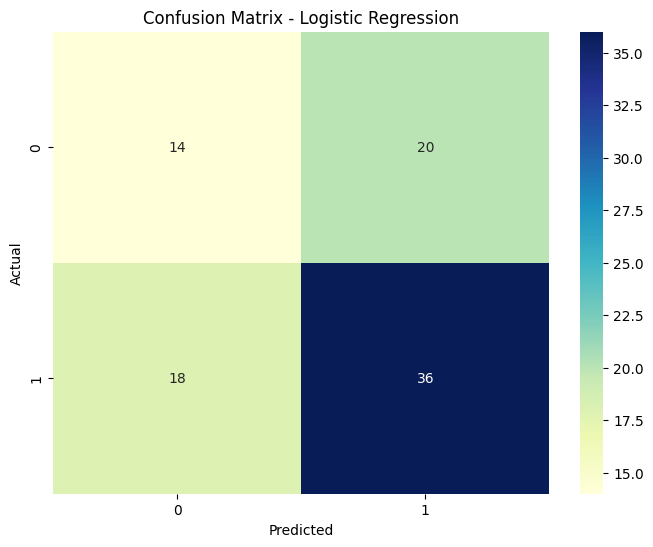

ROC AUC: 0.5746


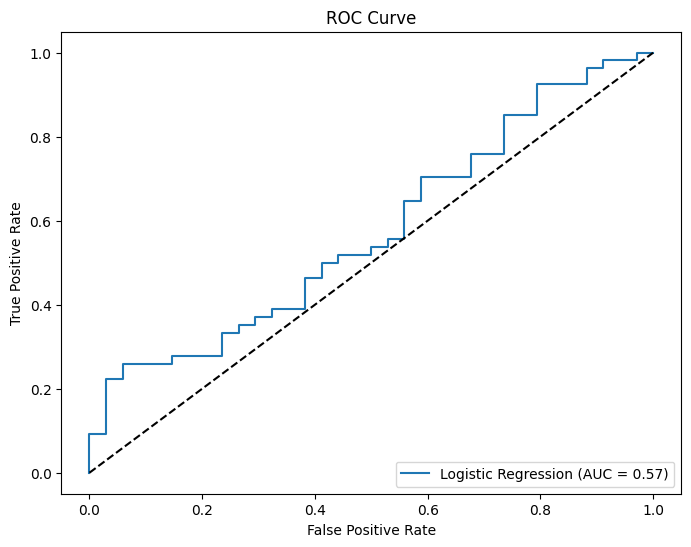


Cross-Validation Scores: [0.57954545 0.59090909 0.51136364 0.65517241 0.55172414]
Mean CV Score: 0.5777429467084639
Standard Deviation of CV Scores: 0.04744493653210374

Top 10 Most Important Features:
         feature  importance
12           RAa    0.651804
27      LVEF_tte    0.569507
34           TVr    0.500950
25         LVIDd    0.481605
26         LVIDs    0.467435
13           RAv    0.397499
20  NIBPd_vitals    0.391104
23            Ad    0.302425
3        CO_fick    0.290870
30           LAd    0.281960
6           PCWv    0.212469
22            As    0.203898
29         LVPWd    0.187055
33           MVr    0.170687
24         tteId    0.163113
10         RVmin    0.161251
35           PVr    0.138305
4            PCW    0.129661
14           RAm    0.120191
7            PAs    0.111382


/var/folders/dz/fbr6_yrs1qd7cqdgs7l6dw780000gn/T/ipykernel_71034/377127690.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')


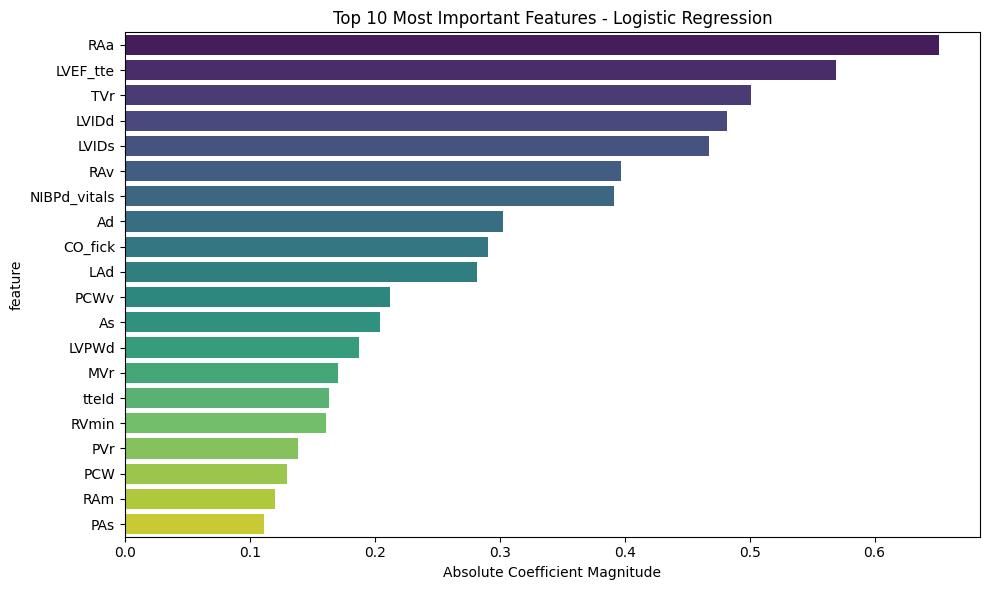

In [32]:
logistic_model = LogisticRegression(
    random_state=42,  # For reproducibility
    max_iter=1000,    # Increase max iterations to ensure convergence
    class_weight='balanced'  # Handle class imbalance
)

# Train and evaluate Logistic Regression
logistic_regression_model = train_and_evaluate(
    logistic_model, 
    "Logistic Regression", 
    X_train, 
    y_train, 
    X_test, 
    y_test
)

# Optional: Perform cross-validation
cv_scores = cross_val_score(logistic_model, X_scaled, Y_encoded, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Optional: Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(logistic_regression_model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 10 Most Important Features - Logistic Regression')
plt.xlabel('Absolute Coefficient Magnitude')
plt.tight_layout()
plt.show()